## Slice grappa 
###### Author: Zimu Huo
###### Date: 05.2022

Slice GRAPPA is used exclusively for SMS, ensuring that the output dimensions match the input dimensions. The kernel is trained for each slice, allowing it to project the SMS data onto each individual slice. Similarly, the slice GRAPPA kernel is obtained through a least squares fit

-------------------------------------------------------------------------
References

    [1] 
    Author:  Setsompop K et al. 
    Title: Blipped-controlled aliasing in parallel imaging for simultaneous multislice echo planar imaging with reduced g-factor penalty
    Link: https://onlinelibrary.wiley.com/doi/10.1002/mrm.23097

In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import util.simulator as simulate
from util.coil import *
from util.fft import *
import util.mask as undersample
from util.sg import *

In [24]:
import numpy as np
import math   
  
def sg(dataR, calib, kh = 5, kw = 5, lamda = 1e-3, inMat = None, inMatrix = None):
    # slice grappa 
    # Author: Zimu 
    [read, freq, numCoil] = dataR.shape
    calib = calib
    [acsHeight, acsWidth, _, numSlice] = calib.shape
    kernSize = kh  * kw  * numCoil
    numTrain = acsHeight * acsWidth
    data = np.zeros([read, freq, numCoil, numSlice], dtype = complex)
    ACS = np.sum(calib, axis=-1)
    if inMat is None:
        inMat = patches(dataR,kh, kw) 
    if inMatrix is None:
        inMatrix =  patches(ACS, kh, kw)
    for sli in range(numSlice):
        outMatrix = calib[...,sli].reshape(-1,numCoil)
        if lamda: 
            [u,s,vh] = np.linalg.svd(inMatrix,full_matrices=False)
            s_inv = np.conj(s) / (np.abs(s)**2 + lamda);
            inMat_inv = vh.conj().T @ np.diag(s_inv) @ u.conj().T;
            w = inMat_inv@outMatrix
        else: 
            w = np.linalg.pinv(inMatrix)@outMatrix
        data[...,sli] = (inMat @ w).reshape(read, freq, numCoil)
    return data


def patches(mat, kh, kw):
    [h, w, coil] = mat.shape
    kSize = kh * kw * coil
    inMatrix = np.zeros([h * w, kSize], dtype = complex)
    num = 0
    for y in range (h):
        ys = np.mod(np.linspace(y - int((kh/2-1)+ 1), y+int((kh/2)), kh, dtype = int), h)
        for x in range(w):
            xs = np.mod(np.linspace(x - int((kw/2-1) + 1), x+int((kw/2)), kw, dtype = int), w)
            inMatrix[num,:] = mat[ys][:,xs][:,:,:].reshape(1,-1)
            num = num + 1
    return inMatrix
        
def get_patches(dataR, calib, kh = 5, kw = 5):
    [read, freq, numCoil] = dataR.shape
    calib = calib
    [acsHeight, acsWidth, _, numSlice] = calib.shape
    kernSize = kh  * kw  * numCoil
    numTrain = acsHeight * acsWidth
    data = np.zeros([read, freq, numCoil, numSlice], dtype = complex)
    ACS = np.sum(calib, axis=-1)
    inMat = patches(dataR,kh, kw) 
    inMatrix =  patches(ACS, kh, kw)
    return inMat, inMatrix 

In [2]:
numSlice =4
R = 4
slice1 = np.load("../lib/slice1_grappa1.npy")
slice2 = np.load("../lib/slice2_grappa1.npy")
slice3 = np.load("../lib/slice3_grappa1.npy")
slice4 = np.load("../lib/slice4_grappa1.npy")
data = np.concatenate((slice1[...,None], slice2[...,None], slice3[...,None], slice4[...,None]), -1)
rawImage = ifft2c(data)
fovHeight, fovWidth, numCoil, _ = rawImage.shape

In [3]:
rawData = np.zeros(rawImage.shape, dtype = complex)
for sli in range (numSlice):
        rawData[:,:,:,sli] = fft2c(rawImage[:,:,:,sli])

In [4]:
cycle = np.arange(0,1,1/numSlice) * 2* np.pi
numAccq = int(numSlice*fovHeight/R)

In [5]:
print(cycle)

[0.         1.57079633 3.14159265 4.71238898]


In [6]:
shift = cycle*numAccq/(2*np.pi)
dataR = fft2c(simulate.multiSliceCAIPI(rawImage, cycle, R))

In [7]:
acsshift = cycle*int(numSlice* 32/R)/(2*np.pi)
acsK = simulate.acs(rawData, (32, 32))
acsIm = ifft2c(acsK)
calib = fft2c(simulate.singleSliceFov(acsIm,acsshift))

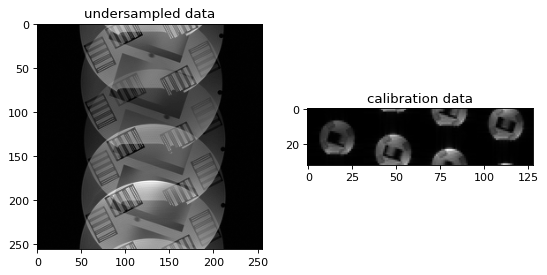

In [20]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(121)
plt.title("undersampled data")
plt.imshow(np.abs(rsos(ifft2c(dataR))), cmap = "gray")
plt.subplot(122)
plt.title("calibration data")
plt.imshow(np.abs(stitch(rsos(ifft2c(calib),-2),1)), cmap = "gray")

In [9]:
recon = sg(dataR, calib)

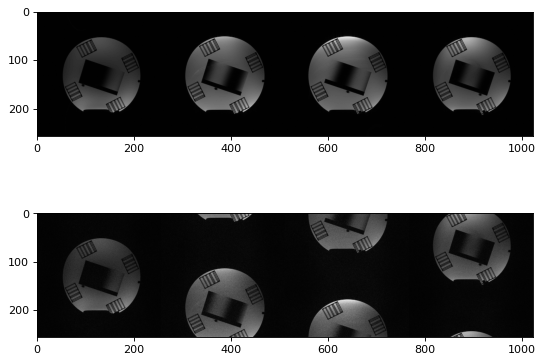

In [18]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(211)
plt.imshow(np.abs(stitch(rsos(rawImage, -2), 1)), cmap = "gray")
plt.subplot(212)
plt.imshow(np.abs(stitch(rsos(ifft2c(recon),-2),1)), cmap = "gray")

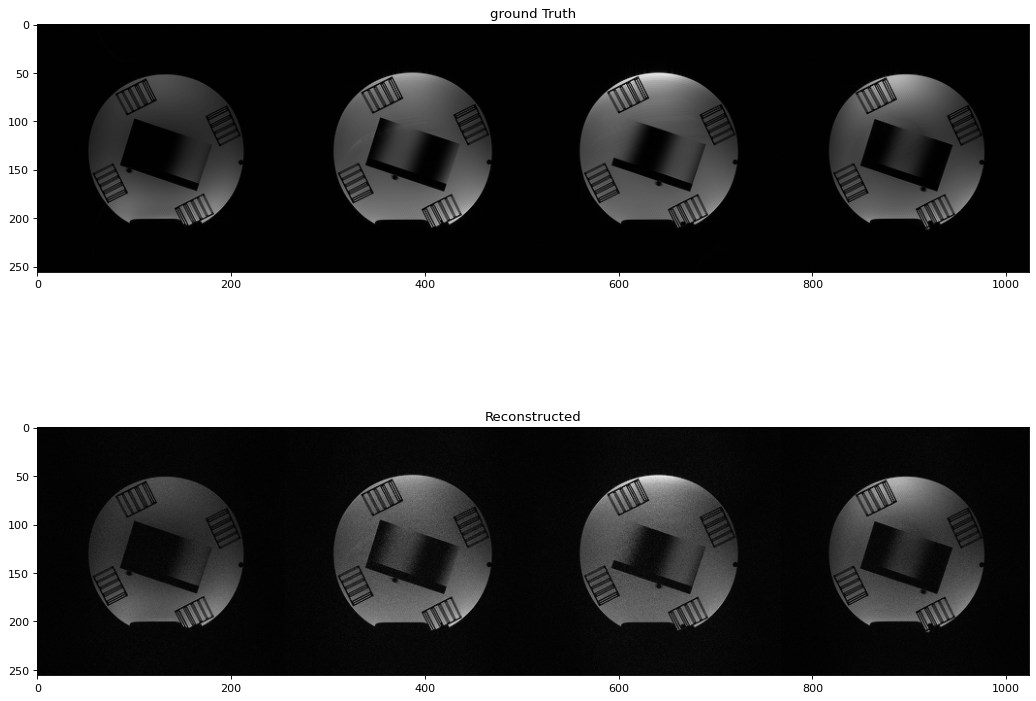

In [21]:
# here we already see a much better result than the standard grappa 
reconshift = cycle*int(numSlice* fovHeight/R)/(2*np.pi) 
recon1 = simulate.singleSliceFov(ifft2c(recon), - reconshift)
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(211)
plt.title("ground Truth")
plt.imshow(np.abs(stitch(rsos(rawImage,-2), 1)), cmap = "gray")
plt.subplot(212)
plt.title("Reconstructed")
plt.imshow(np.abs(stitch(rsos((recon1),-2),1)), cmap = "gray")